# SynFerm Exploratory Data Analysis
#### Targets:
- See some of the basic trends in the data (which BBs react well? which not at all?)
- perform basic statistics (How many successful reactions?)

#### Sections:
1. [Load and filter data](#1)
2. [Investigate "invalid" reactions](#2)
3. [General Statistics](#3)
4. [Building Block Statistics](#4)
5. [Trends within builing block classes](#5)
6. [Trends within builing block classes, corrected for monomers performance](#6)

In [1]:
import os
import re
import sqlite3
import sys
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rc
from rdkit.Chem.AllChem import Compute2DCoords
%matplotlib inline

sys.path.insert(0, os.path.abspath('../..'))
from src.definitions import DB_PATH
from src.util.db_utils import MyDatabaseConnection
from src.util.color_palette import BodeColorPalette

bode_palette = BodeColorPalette()

In [2]:
# settings
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['figure.dpi'] = 100  # this makes the figures bigger in jupyter nb

sns.set_theme(context="paper",
              style="white",
              font_scale=0.7,
              rc={"savefig.transparent": True,
                  "axes.grid": False,
                  "axes.spines.bottom": True,
                  "axes.spines.left": False,
                  "axes.spines.right": False,
                  "axes.spines.top": False,},
             )

### Load and filter data <a id='section_id'></a>

In [3]:
db = MyDatabaseConnection()  # we will use this for various simple queries

In [4]:
con = sqlite3.connect(DB_PATH)
df_full = pd.read_sql('SELECT * FROM experiments', con, index_col='id', coerce_float=False ,parse_dates={'synthesis_date_unixepoch': {'utc': False, 'unit': 's'}})
con.close()
print(f'Number of reactions (in total): {len(df_full)}')

Number of reactions (in total): 58664


### Select experiments for analysis

In [5]:
# show all available experiments with reaction counts
df_full["exp_nr"].value_counts().sort_index()

1        1920
2        1920
3        1920
4        1920
5        1920
6        1920
7        1920
8        1920
9        1920
10       1920
11       1920
12       1920
13       1920
14       1920
15       1920
16       1920
17       1920
18       1920
19       1920
20       1920
21       1920
22       1920
23       1920
24       1920
25       1920
26       1920
27       1920
28       1920
29       1920
99000     384
99001     648
99002     592
99003      16
99004     384
99005     960
Name: exp_nr, dtype: int64

In [6]:
# select experiment numbers for further analysis
start_exp_nr = 4  # kick out invalid experiments (SOP changed after exp3)
end_exp_nr = 29  # (inclusive)

df_full = df_full.loc[df_full['exp_nr'].between(start_exp_nr, end_exp_nr)]  
print(f'Number of reactions since SOP change and without test reactions: {len(df_full)}')

Number of reactions since SOP change and without test reactions: 49920


### Investigate "invalid" reactions <a id=2></a>

In [7]:
# expand the "valid" column to work with it more easily
# add columns for error and warning
df_full["has_error"] = df_full["valid"].notna() & df_full["valid"].str.contains("ERROR")
df_full["has_warning"] = df_full["valid"].notna() & df_full["valid"].str.contains("WARNING")
# add columns for error categories
df_full["has_error_product_peaks"] = df_full["valid"].notna() & df_full["valid"].str.contains("ERROR: multiple peaks for product A")
df_full["has_error_internal_standard"] = df_full["valid"].notna() & (
        df_full["valid"].str.contains("ERROR: IS response <50% of plate median")
        | df_full["valid"].str.contains("ERROR: multiple peaks for IS")
        | df_full["valid"].str.contains("ERROR: IS response >200% of plate median")
)
df_full["has_error_transfer"] = df_full["valid"].notna() & df_full["valid"].str.contains("transfer error")
df_full["has_error_low_volume"] = df_full["valid"].notna() & df_full["valid"].str.contains("ERROR: Dilution survey low volume")
df_full["has_error_other"] = df_full["valid"].notna() & (df_full["valid"].str.contains("ERROR: No monomer") | df_full["valid"].str.contains("ERROR: Monomer solution had lower concentration than required") )
df_full["has_warning_product_peaks"] = df_full["valid"].notna() & df_full["valid"].str.contains("WARNING: multiple peaks for product A")
df_full["has_warning_quality_control"] = df_full["valid"].notna() & df_full["valid"].str.contains("WARNING") & df_full["valid"].str.contains("QC")
df_full

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,valid,has_error,has_warning,has_error_product_peaks,has_error_internal_standard,has_error_transfer,has_error_low_volume,has_error_other,has_warning_product_peaks,has_warning_quality_control
id,,,,,,,,,,,,,,,,,,,,,
10578,5,4,A3,JG255,2021-08-17,I67,M20,T25,Ph023,Mon017,...,WARNING: heating failure on first step; WARNIN...,False,True,False,False,False,False,False,True,False
10579,5,4,A4,JG255,2021-08-17,I67,M20,T39,Ph023,Mon017,...,WARNING: heating failure on first step; WARNIN...,False,True,False,False,False,False,False,True,False
10580,5,4,A5,JG255,2021-08-17,I67,M20,T30,Ph023,Mon017,...,WARNING: heating failure on first step; WARNIN...,False,True,False,False,False,False,False,True,False
10581,5,4,A6,JG255,2021-08-17,I67,M20,T34,Ph023,Mon017,...,WARNING: heating failure on first step; WARNIN...,False,True,False,False,False,False,False,True,False
10582,5,4,A7,JG255,2021-08-17,I67,M20,T17,Ph023,Mon017,...,WARNING: heating failure on first step; ERROR:...,True,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85517,4,3,P5,JG248,2021-07-15,I33,M22,T31,Al038,Mon020,...,WARNING: multiple peaks for product A (3),False,True,False,False,False,False,False,True,False
85518,4,3,P6,JG248,2021-07-15,I33,M22,T40,Al038,Mon020,...,WARNING: multiple peaks for product A (3),False,True,False,False,False,False,False,True,False
85519,4,3,P7,JG248,2021-07-15,I33,M22,T20,Al038,Mon020,...,None,False,False,False,False,False,False,False,False,False


In [8]:
df_full[[col for col in df_full.columns if col.startswith("has_")]].sum()

has_error                       8185
has_warning                    19959
has_error_product_peaks         1301
has_error_internal_standard     6060
has_error_transfer               835
has_error_low_volume             527
has_error_other                  179
has_warning_product_peaks      16731
has_warning_quality_control     2113
dtype: int64

In [9]:
# let's split this into the individual errors/warnings
expanded_warnings = df_full.loc[:,'valid'].str.split(";", expand=True)
expanded_warnings.columns = [f"problem_{i}" for i in expanded_warnings.columns]
df_full = df_full.join(expanded_warnings, how="left")
# sanitize
df_full.replace(' ', np.nan, inplace=True)  # replace whitespace strings with NaN (artifact from splitting)
df_full

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,has_error_low_volume,has_error_other,has_warning_product_peaks,has_warning_quality_control,problem_0,problem_1,problem_2,problem_3,problem_4,problem_5
id,,,,,,,,,,,,,,,,,,,,,
10578,5,4,A3,JG255,2021-08-17,I67,M20,T25,Ph023,Mon017,...,False,False,True,False,WARNING: heating failure on first step,WARNING: multiple peaks for product A (2),None,None,None,None
10579,5,4,A4,JG255,2021-08-17,I67,M20,T39,Ph023,Mon017,...,False,False,True,False,WARNING: heating failure on first step,WARNING: multiple peaks for product A (2),None,None,None,None
10580,5,4,A5,JG255,2021-08-17,I67,M20,T30,Ph023,Mon017,...,False,False,True,False,WARNING: heating failure on first step,WARNING: multiple peaks for product A (2),None,None,None,None
10581,5,4,A6,JG255,2021-08-17,I67,M20,T34,Ph023,Mon017,...,False,False,True,False,WARNING: heating failure on first step,WARNING: multiple peaks for product A (2),None,None,None,None
10582,5,4,A7,JG255,2021-08-17,I67,M20,T17,Ph023,Mon017,...,False,False,False,False,WARNING: heating failure on first step,ERROR: multiple peaks for IS (43),ERROR: IS response <50% of plate median,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85517,4,3,P5,JG248,2021-07-15,I33,M22,T31,Al038,Mon020,...,False,False,True,False,WARNING: multiple peaks for product A (3),None,None,None,None,None
85518,4,3,P6,JG248,2021-07-15,I33,M22,T40,Al038,Mon020,...,False,False,True,False,WARNING: multiple peaks for product A (3),None,None,None,None,None
85519,4,3,P7,JG248,2021-07-15,I33,M22,T20,Al038,Mon020,...,False,False,False,False,None,None,None,None,None,None


In [10]:
# how many reactions have errors?
df_full.has_error.sum()

8185

In [11]:
# how many reactions have warnings?
df_full.has_warning.sum()

19959

In [12]:
# what are the most common problems?
df_full[[col for col in df_full.columns if col.startswith("problem_")]].stack().value_counts()

 ERROR: IS response <50% of plate median      4936
ERROR: multiple peaks for IS (2)              2168
                                             ...  
ERROR: multiple peaks for IS (155)               1
ERROR: multiple peaks for IS (188)               1
 ERROR: multiple peaks for IS (91)               1
ERROR: multiple peaks for IS (135)               1
 ERROR: multiple peaks for IS (128)              1
Length: 380, dtype: int64

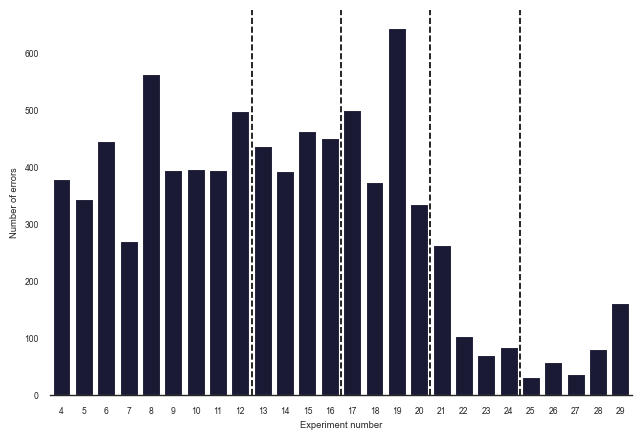

In [23]:
# Generate a histogram showing the distribution of errors across experiments
plt.figure(figsize=(7.5, 5))
sns.barplot(x=df_full.loc[df_full.has_error, "exp_nr"].value_counts().sort_index().index,
            y=df_full.loc[df_full.has_error, "exp_nr"].value_counts().sort_index().values,
            color=bode_palette.blue,
            )
plt.xlabel('Experiment number')
plt.ylabel('Number of errors')
plt.axvline(x=8.5, color="black", linestyle='--', label='Changed to OT2 source preparation before exp13')
plt.axvline(x=12.5, color="black", linestyle='--', label='Changed to full automation before exp17')
plt.axvline(x=16.5, color="black", linestyle='--', label='Changed to Eppendorf heat seal before exp21')
plt.axvline(x=20.5, color="black", linestyle='--', label='Changed to Agilent heat seal before exp21')
plt.savefig("/Users/julian/Desktop/number_of_errors_per_experiment.png", dpi=300, bbox_inches='tight')

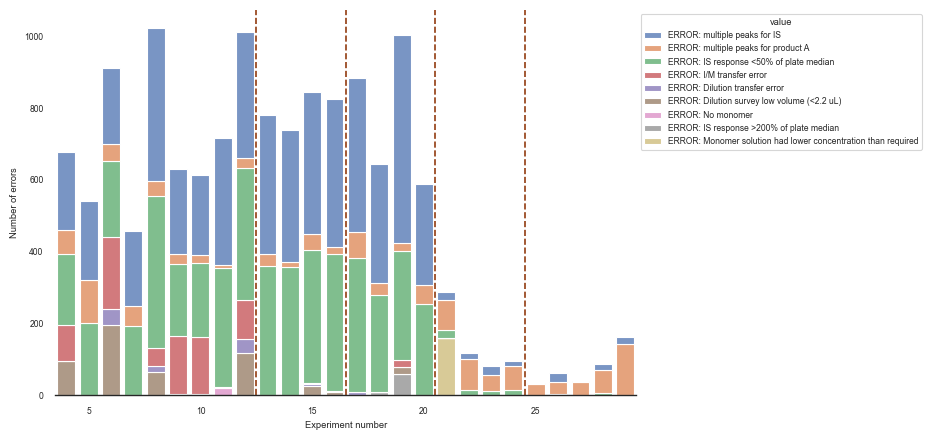

In [17]:
# Generate a histogram showing the distribution of errors across experiments
# Function to remove the value in parentheses
def remove_parentheses_value(s):
    if isinstance(s, str):
        return re.sub(r'\s\(\d+\)', '', s)
    return s


# Keep only the relevant columns
relevant_columns = ['exp_nr'] + [col for col in df_full.columns if 'problem_' in col]
df_relevant = df_full[relevant_columns].copy()

for col in relevant_columns:
    if col != 'exp_nr':
        df_relevant[col] = df_relevant[col].apply(remove_parentheses_value)
        df_relevant[col] = df_relevant[col].apply(lambda x: x.strip() if isinstance(x, str) else x)

# right now we are only interested in errors
df_relevant_errors = df_relevant.replace(re.compile('.*WARNING.*'), pd.NA)

# Melt the DataFrame
df_melted = pd.melt(df_relevant_errors, id_vars=['exp_nr'], var_name='columns', value_name='value')

# Filter out None values
df_filtered = df_melted[df_melted['value'].notnull()]

# Create the histogram
plt.figure(figsize=(7.5, 5))
ax = sns.histplot(data=df_filtered, x='exp_nr', hue='value', multiple='stack', discrete=True, shrink=.8)
plt.axvline(x=12.5, color=bode_palette.orange, linestyle='--', label='Changed to OT2 source preparation before exp13')
plt.axvline(x=16.5, color=bode_palette.orange, linestyle='--', label='Changed to full automation before exp17')
plt.axvline(x=20.5, color=bode_palette.orange, linestyle='--', label='Changed to Eppendorf heat seal before exp21')
plt.axvline(x=24.5, color=bode_palette.orange, linestyle='--', label='Changed to Agilent heat seal before exp25')
plt.xlim(3.5, 29.5)
plt.xlabel('Experiment number')
plt.ylabel('Number of errors')
# Move the legend outside the plot to the right
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig("/Users/julian/Desktop/type_of_errors_per_experiment.png", dpi=300, bbox_inches='tight')

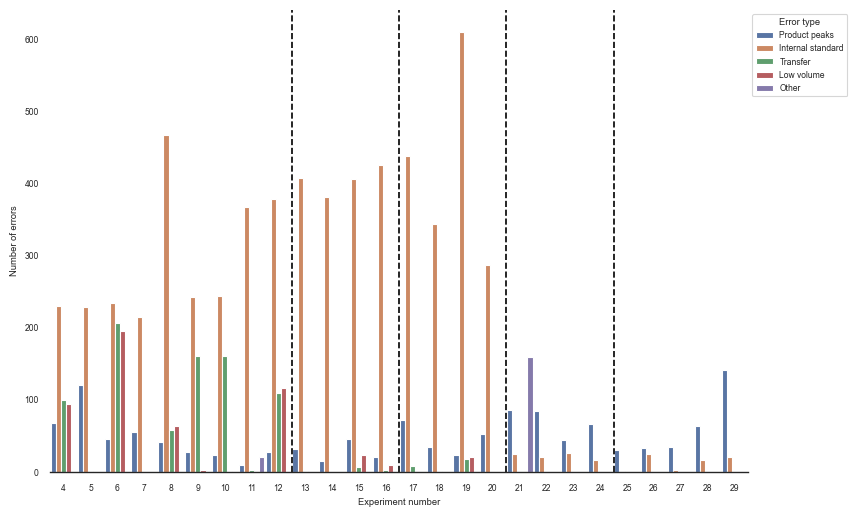

In [22]:
# Generate a histogram showing the distribution of errors across experiments, but use the error bins instead of the individual errors

# Keep only the relevant columns
relevant_columns = ['exp_nr'] + [col for col in df_full.columns if 'has_error_' in col]
df_relevant = df_full[relevant_columns].copy()

# Reshape the DataFrame
df_grouped = df_relevant.groupby('exp_nr').sum().reset_index().melt(id_vars=["exp_nr"], var_name="columns", value_name='value')
# Filter out None values
df_grouped = df_grouped[df_grouped['value'].notnull()]
# Plot the histogram
plt.figure(figsize=(9, 6))
ax = sns.barplot(data=df_grouped, x="exp_nr", y="value", hue='columns', dodge=True, width=.95)
plt.axvline(x=8.5, color="black", linestyle='--', label='Changed to OT2 source preparation before exp13')
plt.axvline(x=12.5, color="black", linestyle='--', label='Changed to full automation before exp17')
plt.axvline(x=16.5, color="black", linestyle='--', label='Changed to Eppendorf heat seal before exp21')
plt.axvline(x=20.5, color="black", linestyle='--', label='Changed to Agilent heat seal before exp25')
plt.xlabel('Experiment number')
plt.ylabel('Number of errors')
handles, labels = ax.get_legend_handles_labels()
ax.legend(title = "Error type", loc='upper left', bbox_to_anchor=(1, 1), handles=handles[4:], labels=[l.removeprefix("has_error_").replace("_", " ").strip().capitalize() for l in labels[4:]])
plt.savefig("/Users/julian/Desktop/type_of_errors_per_experiment_binned.png", dpi=300, bbox_inches='tight')


Let's have a look at the worst offenders. there might be a structural reason why they give multiple peaks in LCMS

In [34]:
x = df_full.loc[df_full['valid'].notna() & df_full['valid'].str.contains('multiple peaks for product A'), ['initiator']].value_counts()
x

initiator
I6           710
I22          639
I7           582
I3           570
I65          562
            ... 
I63           46
I45           10
I74            9
I55            8
I18            7
Length: 69, dtype: int64

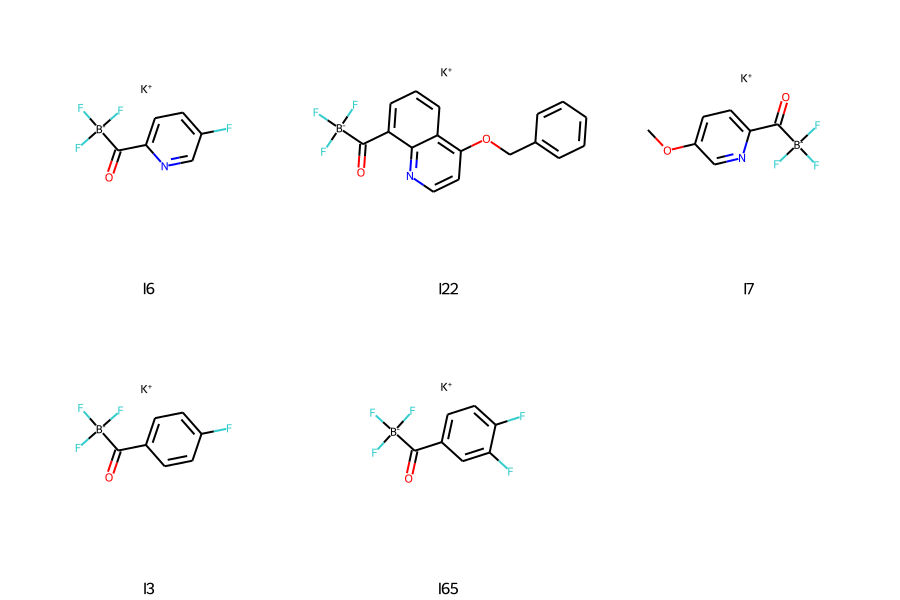

In [35]:
# let's look at these molecules
mols = []
for bb in x.head(5).index.to_list():
    mols.append(db.get_mol(short=bb[0]))
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, subImgSize=(300,300), legends=[bb[0] for bb in x.index.to_list()])

In [41]:
x = df_full.loc[df_full['valid'].notna() & df_full['valid'].str.contains('multiple peaks for product A'), ['monomer']].value_counts()
x

monomer
M2         659
M1         611
M52        585
M72        572
M51        528
          ... 
M12         88
M36         47
M58         27
M27          7
M39          4
Length: 73, dtype: int64

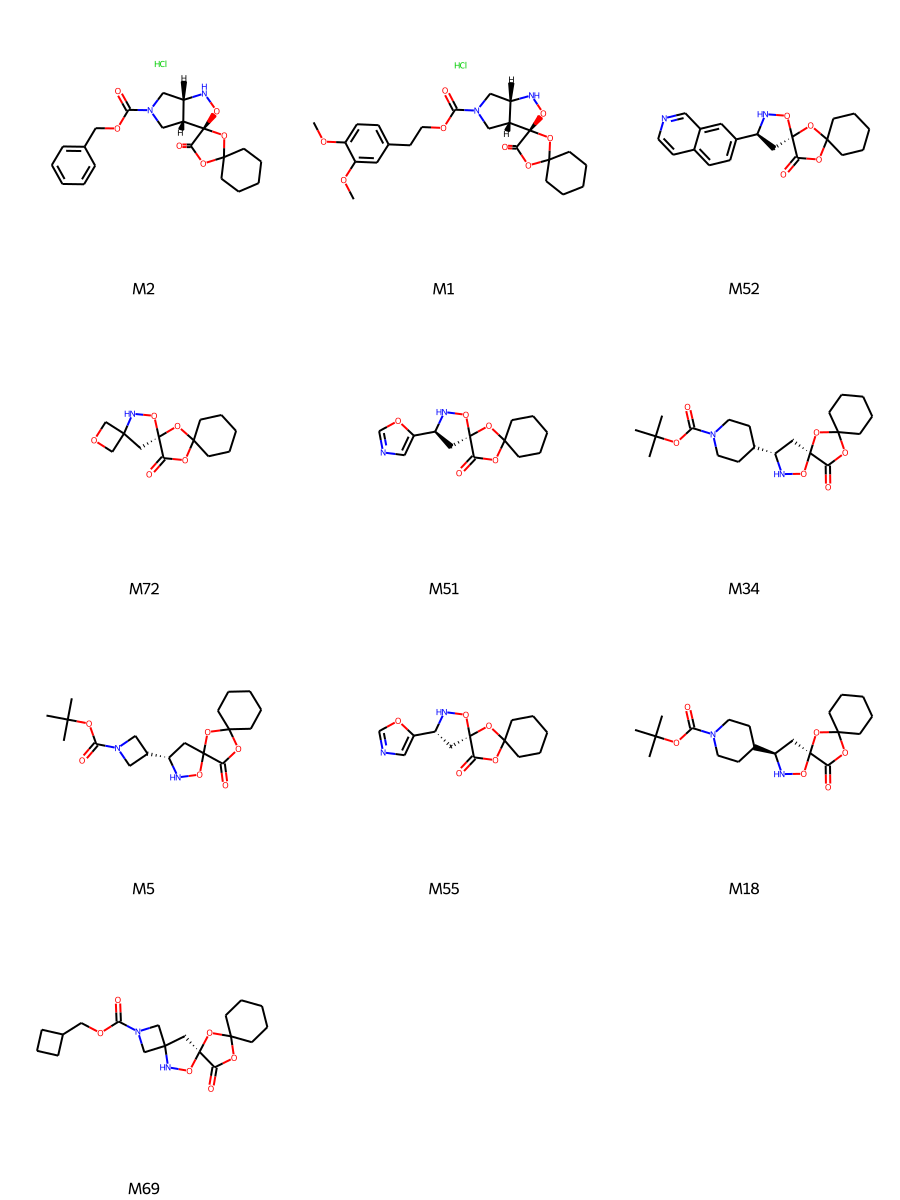

In [37]:
# let's look at these molecules
mols = []
for bb in x.head(10).index.to_list():
    mols.append(db.get_mol(short=bb[0]))
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, subImgSize=(300,300), legends=[bb[0] for bb in x.index.to_list()])

In [39]:
x = df_full.loc[df_full['valid'].notna() & df_full['valid'].str.contains('multiple peaks for product A'), ['terminator']].value_counts()
x

terminator
T36           915
T34           837
T22           811
T38           782
T31           774
T32           756
T19           742
T23           718
T21           673
T33           631
T39           624
T20           618
T30           607
T29           607
T40           605
T28           604
T26           592
T25           572
T27           555
T35           534
T41           499
T1            400
T37           387
T17           354
T3            276
T12           252
T7            247
T24           230
T13           211
T2            201
T10           192
T6            165
T8            161
T16           155
T11           139
T4            130
T14           127
T15           121
T18           121
T5            101
T9              6
dtype: int64

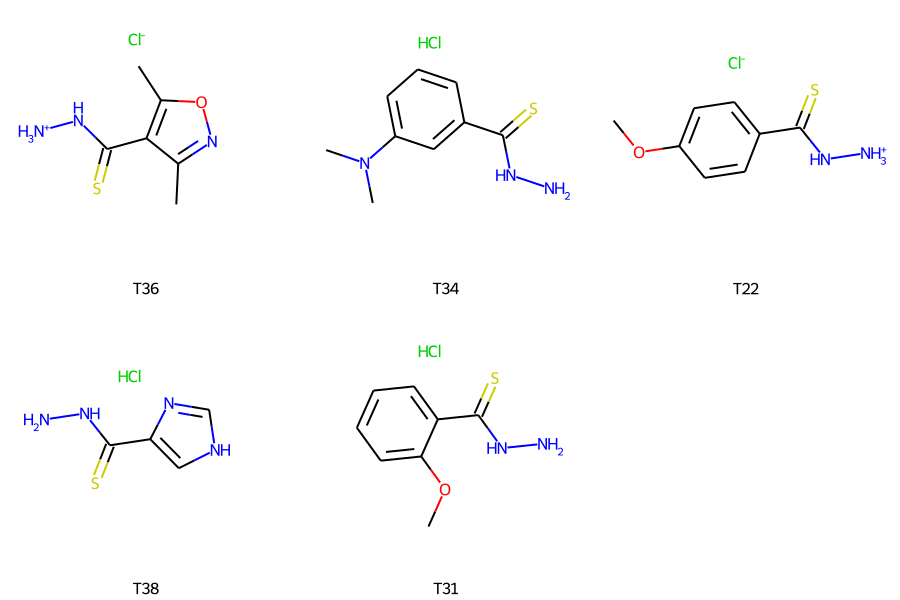

In [40]:
# let's look at these molecules
mols = []
for bb in x.head(5).index.to_list():
    mols.append(db.get_mol(short=bb[0]))
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, subImgSize=(300,300), legends=[bb[0] for bb in x.index.to_list()])

#### Remove invalid reactions
It seems reasonable to assume that up to 4 peaks for A could be from diasteromers + regioisomers so we will accept anything that has 4 or less peaks for A into our cleaned data set

In [15]:
df = df_full.loc[df_full.has_errord
                 | (df_full['valid'] == 'heating failure') 
                 | (df_full['valid'] == 'too many peaks for product A (2)') 
                 | (df_full['valid'] == 'too many peaks for product A (3)')
                 | (df_full['valid'] == 'too many peaks for product A (4)')
                ] 
print(f'Number of reactions after removing invalid entries: {len(df)}')

Number of reactions after removing invalid entries: 40691


In [16]:
df = df.loc[~df['product_A_lcms_ratio'].isna()]  # remove all entries where product A is NaN (these are the entries not yet measured)
print(f'Number of reactions after removing NaN entries: {len(df)}')

Number of reactions after removing NaN entries: 40691


In [17]:
df

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,product_A_smiles,product_B_smiles,product_C_smiles,product_D_smiles,product_E_smiles,product_F_smiles,product_G_smiles,product_H_smiles,vl_id,valid
id,,,,,,,,,,,,,,,,,,,,,
10578,5,4,A3,JG255,2021-08-17,I67,M20,T25,Ph023,Mon017,...,CC(C)(C)OC(=O)CC[C@@H](Cc1nnc(C=Cc2ccccc2)s1)N...,CC(C)(C)OC(=O)CC[C@@H](CC1(C(=O)O)NN=C(C=Cc2cc...,CC(C)(C)OC(=O)CC[C@H]1CC2(C(=O)[O-])SC(C=Cc3cc...,Clc1ccc(-c2nnc(C=Cc3ccccc3)s2)cc1,C(=Cc1nnc(C=Cc2ccccc2)s1)c1ccccc1,CC(C)(C)OC(=O)CC[C@@H](CC(=O)C(=O)O)NC(=O)c1cc...,CC(C)(C)OC(=O)CC[C@@H](CC(=O)O)NC(=O)c1ccc(Cl)cc1,CC(C)(C)OC(=O)CCC=Cc1nnc(C=Cc2ccccc2)s1,201048,heating failure
10579,5,4,A4,JG255,2021-08-17,I67,M20,T39,Ph023,Mon017,...,CC(C)(C)OC(=O)CC[C@@H](Cc1nnc(-c2cn[nH]c2)s1)N...,CC(C)(C)OC(=O)CC[C@@H](CC1(C(=O)O)NN=C(c2cn[nH...,CC(C)(C)OC(=O)CC[C@H]1CC2(C(=O)[O-])SC(c3cn[nH...,Clc1ccc(-c2nnc(-c3cn[nH]c3)s2)cc1,c1n[nH]cc1-c1nnc(-c2cn[nH]c2)s1,CC(C)(C)OC(=O)CC[C@@H](CC(=O)C(=O)O)NC(=O)c1cc...,CC(C)(C)OC(=O)CC[C@@H](CC(=O)O)NC(=O)c1ccc(Cl)cc1,CC(C)(C)OC(=O)CCC=Cc1nnc(-c2cn[nH]c2)s1,201062,heating failure
10580,5,4,A5,JG255,2021-08-17,I67,M20,T30,Ph023,Mon017,...,CC(C)(C)OC(=O)CC[C@@H](Cc1nnc(-c2cc(Cl)cc(Cl)c...,CC(C)(C)OC(=O)CC[C@@H](CC1(C(=O)O)NN=C(c2cc(Cl...,CC(C)(C)OC(=O)CC[C@H]1CC2(C(=O)[O-])SC(c3cc(Cl...,Clc1ccc(-c2nnc(-c3cc(Cl)cc(Cl)c3)s2)cc1,Clc1cc(Cl)cc(-c2nnc(-c3cc(Cl)cc(Cl)c3)s2)c1,CC(C)(C)OC(=O)CC[C@@H](CC(=O)C(=O)O)NC(=O)c1cc...,CC(C)(C)OC(=O)CC[C@@H](CC(=O)O)NC(=O)c1ccc(Cl)cc1,CC(C)(C)OC(=O)CCC=Cc1nnc(-c2cc(Cl)cc(Cl)c2)s1,201053,heating failure
10581,5,4,A6,JG255,2021-08-17,I67,M20,T34,Ph023,Mon017,...,CN(C)c1cccc(-c2nnc(C[C@H](CCC(=O)OC(C)(C)C)NC(...,CN(C)c1cccc(C2=NNC(C[C@H](CCC(=O)OC(C)(C)C)NC(...,CN(C)c1cccc(C2=N[N+]3=C(c4ccc(Cl)cc4)N[C@@H](C...,CN(C)c1cccc(-c2nnc(-c3ccc(Cl)cc3)s2)c1,CN(C)c1cccc(-c2nnc(-c3cccc(N(C)C)c3)s2)c1,CC(C)(C)OC(=O)CC[C@@H](CC(=O)C(=O)O)NC(=O)c1cc...,CC(C)(C)OC(=O)CC[C@@H](CC(=O)O)NC(=O)c1ccc(Cl)cc1,CN(C)c1cccc(-c2nnc(C=CCCC(=O)OC(C)(C)C)s2)c1,201057,heating failure
10582,5,4,A7,JG255,2021-08-17,I67,M20,T17,Ph023,Mon017,...,CCOc1ccc2nc(C[C@H](CCC(=O)OC(C)(C)C)NC(=O)c3cc...,CCOc1ccc2c(c1)SC(C[C@H](CCC(=O)OC(C)(C)C)NC(=O...,CCOc1ccc2c(c1)SC1(C(=O)[O-])C[C@H](CCC(=O)OC(C...,CCOc1ccc2nc(-c3ccc(Cl)cc3)sc2c1,CCOc1ccc(N)c(SSc2cc(OCC)ccc2N)c1,CC(C)(C)OC(=O)CC[C@@H](CC(=O)C(=O)O)NC(=O)c1cc...,CC(C)(C)OC(=O)CC[C@@H](CC(=O)O)NC(=O)c1ccc(Cl)cc1,CCOc1ccc2nc(C=CCCC(=O)OC(C)(C)C)sc2c1,201040,heating failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85517,4,3,P5,JG248,2021-07-15,I33,M22,T31,Al038,Mon020,...,COc1ccccc1-c1nnc(C[C@@H](NC(=O)C(C)c2ccccc2)c2...,COc1ccccc1C1=NNC(C[C@@H](NC(=O)C(C)c2ccccc2)c2...,COc1ccccc1C1=N[N+]2=C(C(C)c3ccccc3)N[C@@H](c3c...,COc1ccccc1-c1nnc(C(C)c2ccccc2)s1,COc1ccccc1-c1nnc(-c2ccccc2OC)s1,CC(C(=O)N[C@H](CC(=O)C(=O)O)c1ccccc1F)c1ccccc1,CC(C(=O)N[C@H](CC(=O)O)c1ccccc1F)c1ccccc1,COc1ccccc1-c1nnc(C=Cc2ccccc2F)s1,97980,None
85518,4,3,P6,JG248,2021-07-15,I33,M22,T40,Al038,Mon020,...,CC(C(=O)N[C@H](Cc1nnc(-c2ccc3[nH]nnc3c2)s1)c1c...,CC(C(=O)N[C@H](CC1(C(=O)O)NN=C(c2ccc3[nH]nnc3c...,CC(C1=[N+]2N=C(c3ccc4[nH]nnc4c3)SC2(C(=O)[O-])...,CC(c1ccccc1)c1nnc(-c2ccc3[nH]nnc3c2)s1,c1cc2[nH]nnc2cc1-c1nnc(-c2ccc3[nH]nnc3c2)s1,CC(C(=O)N[C@H](CC(=O)C(=O)O)c1ccccc1F)c1ccccc1,CC(C(=O)N[C@H](CC(=O)O)c1ccccc1F)c1ccccc1,Fc1ccccc1C=Cc1nnc(-c2ccc3[nH]nnc3c2)s1,97989,None
85519,4,3,P7,JG248,2021-07-15,I33,M22,T20,Al038,Mon020,...,CC(C(=O)N[C@H](Cc1nnc(-c2cccs2)s1)c1ccccc1F)c1...,CC(C(=O)N[C@H](CC1(C(=O)O)NN=C(c2cccs2)S1)c1cc...,CC(C1=[N+]2N=C(c3cccs3)SC2(C(=O)[O-])C[C@H](c2...,CC(c1ccccc1)c1nnc(-c2cccs2)s1,c1csc(-c2nnc(-c3cccs3)s2)c1,CC(C(=O)N[C@H](CC(=O)C(=O)O)c1ccccc1F)c1ccccc1,CC(C(=O)N[C@H](CC(=O)O)c1ccccc1F)c1ccccc1,Fc1ccccc1C=Cc1nnc(-c2cccs2)s1,97969,None


Now we have a cleaned dataset. Let's try some basic statistics

How many reactions are successful (i.e. normalized lmcs ratio for A > threshold ?)

In [18]:
# first min-max normalize all the lcms columns seperately

df = deepcopy(df)
lcms_df = df[['product_A_lcms_ratio', 'product_B_lcms_ratio', 'product_C_lcms_ratio', 'product_D_lcms_ratio', 'product_E_lcms_ratio', 'product_F_lcms_ratio', 'product_G_lcms_ratio', 'product_H_lcms_ratio']]
df[['A_normalized','B_normalized', 'C_normalized', 'D_normalized', 'E_normalized', 'F_normalized', 'G_normalized', 'H_normalized']] = (lcms_df-lcms_df.min())/(lcms_df.max()-lcms_df.min())
df                                      

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,vl_id,valid,A_normalized,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized
id,,,,,,,,,,,,,,,,,,,,,
10578,5,4,A3,JG255,2021-08-17,I67,M20,T25,Ph023,Mon017,...,201048,heating failure,0.228376,0.145169,0.004820,0.000000,0.012145,0.006604,0.059794,0.000278
10579,5,4,A4,JG255,2021-08-17,I67,M20,T39,Ph023,Mon017,...,201062,heating failure,0.035917,0.105225,0.004056,0.000000,0.001908,0.009637,0.062440,0.000000
10580,5,4,A5,JG255,2021-08-17,I67,M20,T30,Ph023,Mon017,...,201053,heating failure,0.087476,0.098541,0.000710,0.000000,0.000000,0.008287,0.061370,0.000000
10581,5,4,A6,JG255,2021-08-17,I67,M20,T34,Ph023,Mon017,...,201057,heating failure,0.200950,0.288984,0.001253,0.000020,0.008349,0.009118,0.072213,0.000205
10582,5,4,A7,JG255,2021-08-17,I67,M20,T17,Ph023,Mon017,...,201040,heating failure,0.067068,0.000000,0.000000,0.000000,0.000000,0.007924,0.607977,0.000581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85517,4,3,P5,JG248,2021-07-15,I33,M22,T31,Al038,Mon020,...,97980,None,0.244273,0.065822,0.004611,0.061600,0.077136,0.002157,0.003967,0.002621
85518,4,3,P6,JG248,2021-07-15,I33,M22,T40,Al038,Mon020,...,97989,None,0.018205,0.021527,0.000000,0.010246,0.004689,0.006578,0.005230,0.000092
85519,4,3,P7,JG248,2021-07-15,I33,M22,T20,Al038,Mon020,...,97969,None,0.064448,0.024756,0.001517,0.024114,0.009596,0.004538,0.004106,0.000566


In [19]:
# add information about reactant classes to df
def get_reaction_type_for_series(ser):
    new = []
    for i in ser:
        new.append(db.get_reactant_class(i))
    return pd.Series(data=new)
        
df[['initiator_type', 'monomer_type', 'terminator_type']] = df[['initiator', 'monomer', 'terminator']].apply(get_reaction_type_for_series, axis=1)
df

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized,initiator_type,monomer_type,terminator_type
id,,,,,,,,,,,,,,,,,,,,,
10578,5,4,A3,JG255,2021-08-17,I67,M20,T25,Ph023,Mon017,...,0.145169,0.004820,0.000000,0.012145,0.006604,0.059794,0.000278,KAT_arom,Mon_sub_3,TerTH
10579,5,4,A4,JG255,2021-08-17,I67,M20,T39,Ph023,Mon017,...,0.105225,0.004056,0.000000,0.001908,0.009637,0.062440,0.000000,KAT_arom,Mon_sub_3,TerTH
10580,5,4,A5,JG255,2021-08-17,I67,M20,T30,Ph023,Mon017,...,0.098541,0.000710,0.000000,0.000000,0.008287,0.061370,0.000000,KAT_arom,Mon_sub_3,TerTH
10581,5,4,A6,JG255,2021-08-17,I67,M20,T34,Ph023,Mon017,...,0.288984,0.001253,0.000020,0.008349,0.009118,0.072213,0.000205,KAT_arom,Mon_sub_3,TerTH
10582,5,4,A7,JG255,2021-08-17,I67,M20,T17,Ph023,Mon017,...,0.000000,0.000000,0.000000,0.000000,0.007924,0.607977,0.000581,KAT_arom,Mon_sub_3,TerABT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85517,4,3,P5,JG248,2021-07-15,I33,M22,T31,Al038,Mon020,...,0.065822,0.004611,0.061600,0.077136,0.002157,0.003967,0.002621,KAT_al,Mon_sub_3,TerTH
85518,4,3,P6,JG248,2021-07-15,I33,M22,T40,Al038,Mon020,...,0.021527,0.000000,0.010246,0.004689,0.006578,0.005230,0.000092,KAT_al,Mon_sub_3,TerTH
85519,4,3,P7,JG248,2021-07-15,I33,M22,T20,Al038,Mon020,...,0.024756,0.001517,0.024114,0.009596,0.004538,0.004106,0.000566,KAT_al,Mon_sub_3,TerTH


### General Statistics <a id=3></a>

Let's look at how well reactions have worked across the (cleaned) data set

In [20]:
for threshold in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]:
    t_and_f = (df['A_normalized'] >= threshold).value_counts()
    print(f'This ratio of reactions is above the {threshold:.1%} threshold: {t_and_f[True] / (t_and_f[True]+ t_and_f[False]):.1%}')

This ratio of reactions is above the 0.1% threshold: 63.7%
This ratio of reactions is above the 0.5% threshold: 48.2%
This ratio of reactions is above the 1.0% threshold: 39.8%
This ratio of reactions is above the 5.0% threshold: 17.9%
This ratio of reactions is above the 10.0% threshold: 8.9%
This ratio of reactions is above the 20.0% threshold: 3.0%


For a graphical assessment, we plot the histogramms for all normalized product yields

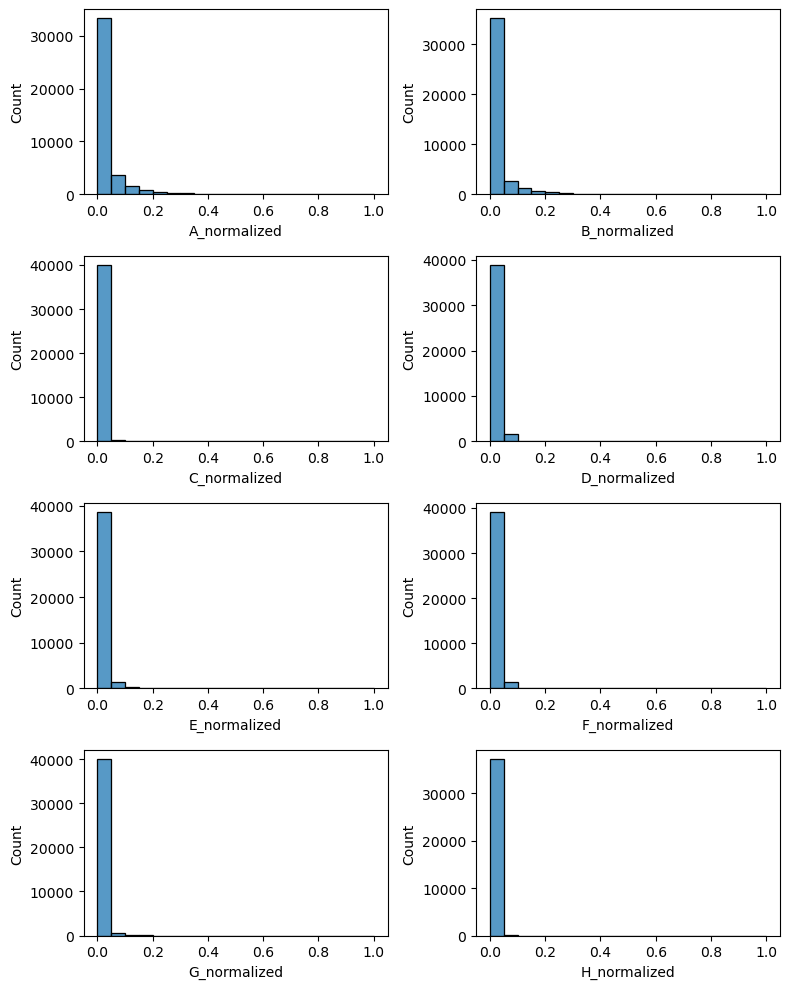

In [21]:
nbins = 20
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(8,10))
sns.histplot(df['A_normalized'], bins=nbins, ax=axs[0][0])
sns.histplot(df['B_normalized'], bins=nbins, ax=axs[0][1])
sns.histplot(df['C_normalized'], bins=nbins, ax=axs[1][0])
sns.histplot(df['D_normalized'], bins=nbins, ax=axs[1][1])
sns.histplot(df['E_normalized'], bins=nbins, ax=axs[2][0])
sns.histplot(df['F_normalized'], bins=nbins, ax=axs[2][1])
sns.histplot(df['G_normalized'], bins=nbins, ax=axs[3][0])
sns.histplot(df['H_normalized'], bins=nbins, ax=axs[3][1])
plt.tight_layout()
plt.show()

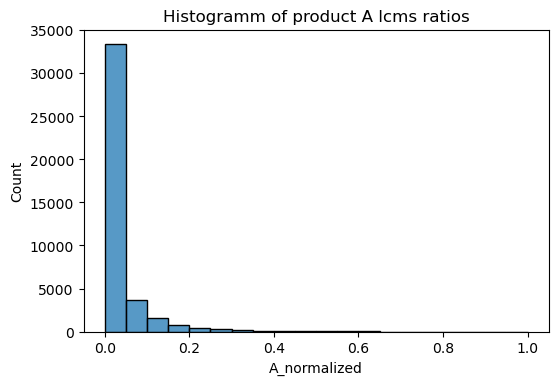

In [22]:
plt.figure()
sns.histplot(df['A_normalized'], bins=20)
plt.title('Histogramm of product A lcms ratios')
plt.show()

<Figure size 600x400 with 0 Axes>

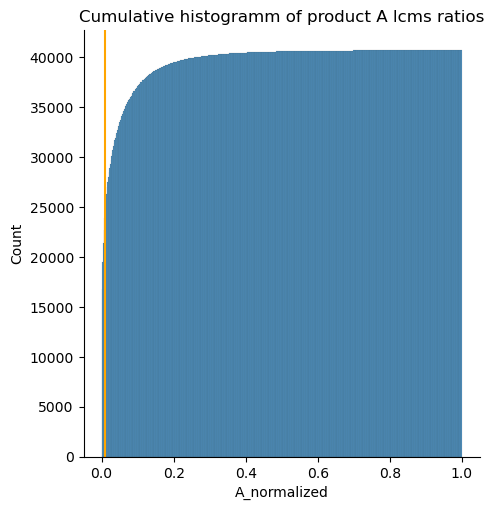

In [23]:
# let's see the same as a cumulative histogramm
plt.figure()
sns.displot(df['A_normalized'], cumulative=True)
plt.title('Cumulative histogramm of product A lcms ratios')
plt.axvline(x=0.01, color='orange')
plt.show()

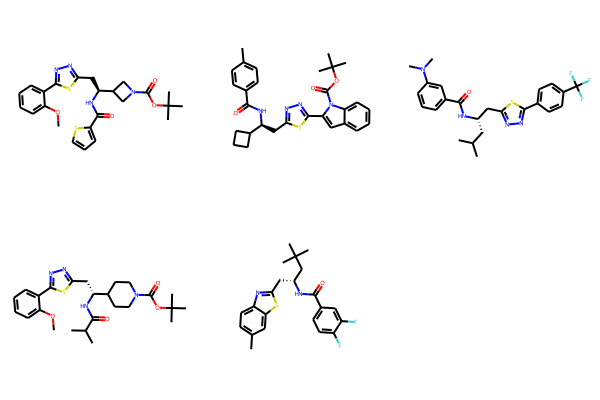

In [24]:
# What products have the highest "yields"?

products = []
for vl_id in df.sort_values('A_normalized', ascending=False).head(5)['vl_id']:
    products.append(db.get_vl_member(vl_id))
[Compute2DCoords(p) for p in products]
Draw.MolsToGridImage(products)

In [25]:
# let's check the highest "yielding" reaction
df.sort_values('A_normalized', ascending=False).head(1)

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized,initiator_type,monomer_type,terminator_type
id,,,,,,,,,,,,,,,,,,,,,
61787,18,1,N15,JG333,2022-05-31,I9,M5,T31,2-Thio001,Mon096,...,0.253225,0.000999,0.006475,0.035807,0.003142,0.002776,0.000178,KAT_hetarom,Mon_sub_3,TerTH


### Building Block statistics <a id=4></a>

Let's look into details: __For each initator, how many reactions have worked above the threshold?__

In [26]:
THRESHOLD = 0.01

In [27]:
def calc_success_rate(df, column, threshold, sort_results=True):
    """
    Take a dataframe df, where for one column of interest, for each unique identifier in that column, the frequency
    of successful reactions (as indicated by the threshold) is calculated.
    :param df: pandas.DataFrame
    :param column: Column by which to group, e.g. monomer or monomer_type
    :param threshold: float, threshold for success
    :return: pandas.DataFrame
    """
    success_rates = []
    for i in df[column].unique():
        df_i = df.loc[df[column] == i]
        n_all = len(df_i)
        n_success = len(df_i.loc[df['A_normalized'] >= threshold])
        success_rates.append([i, n_success, n_all, n_success/n_all])
    if sort_results is True:
        success_rates = sorted(success_rates, key=lambda x: int(x[0][1:]))
    return pd.DataFrame(success_rates, columns=[column, 'n_success', 'n_all', 'success_rate'])

In [28]:
# we calculate success rates for all initiators
success_rates_by_initiator = calc_success_rate(df, 'initiator', THRESHOLD)
for _, i in success_rates_by_initiator.iterrows():
    print(f'Success rate for {i[0]}: {i[3]:.1%} ({i[1]}/{i[2]})')

Success rate for I2: 52.9% (281/531)
Success rate for I3: 51.8% (477/921)
Success rate for I4: 37.6% (189/503)
Success rate for I5: 50.4% (254/504)
Success rate for I6: 38.8% (336/865)
Success rate for I7: 60.0% (544/906)
Success rate for I8: 54.6% (278/509)
Success rate for I9: 48.7% (267/548)
Success rate for I10: 44.2% (417/944)
Success rate for I11: 35.0% (200/571)
Success rate for I12: 35.8% (178/497)
Success rate for I13: 41.4% (232/561)
Success rate for I14: 37.2% (182/489)
Success rate for I15: 45.6% (211/463)
Success rate for I17: 41.1% (381/926)
Success rate for I18: 0.9% (5/557)
Success rate for I19: 32.6% (170/522)
Success rate for I20: 35.6% (183/514)
Success rate for I21: 38.3% (111/290)
Success rate for I22: 35.0% (300/857)
Success rate for I23: 25.6% (113/441)
Success rate for I24: 50.6% (158/312)
Success rate for I25: 50.4% (500/993)
Success rate for I26: 42.9% (237/552)
Success rate for I27: 50.2% (313/624)
Success rate for I28: 16.9% (91/537)
Success rate for I29: 39

In [29]:
# let's do the same for monomers
success_rates_by_monomer = calc_success_rate(df, 'monomer', THRESHOLD)
for _, i in success_rates_by_monomer.iterrows():
    print(f'Success rate for {i[0]}: {i[3]:.1%} ({i[1]}/{i[2]})')

Success rate for M1: 40.6% (259/638)
Success rate for M2: 46.3% (285/615)
Success rate for M3: 14.5% (77/530)
Success rate for M4: 36.8% (179/486)
Success rate for M5: 72.0% (353/490)
Success rate for M6: 35.6% (114/320)
Success rate for M7: 19.7% (63/320)
Success rate for M8: 15.2% (73/480)
Success rate for M9: 30.2% (145/480)
Success rate for M10: 63.9% (484/758)
Success rate for M11: 46.9% (226/482)
Success rate for M12: 0.0% (0/175)
Success rate for M13: 57.5% (368/640)
Success rate for M14: 60.4% (483/800)
Success rate for M15: 52.7% (337/640)
Success rate for M16: 61.9% (227/367)
Success rate for M17: 69.0% (573/831)
Success rate for M18: 64.4% (671/1042)
Success rate for M19: 15.4% (14/91)
Success rate for M20: 73.7% (484/657)
Success rate for M21: 61.4% (366/596)
Success rate for M22: 48.1% (308/640)
Success rate for M23: 75.4% (362/480)
Success rate for M24: 82.1% (192/234)
Success rate for M26: 40.0% (320/800)
Success rate for M27: 0.0% (0/602)
Success rate for M28: 49.7% (38

In [30]:
# and the same for terminators
success_rates_by_terminator = calc_success_rate(df, 'terminator', THRESHOLD)
for _, i in success_rates_by_terminator.iterrows():
    print(f'Success rate for {i[0]}: {i[3]:.1%} ({i[1]}/{i[2]})')

Success rate for T1: 39.3% (558/1420)
Success rate for T2: 28.9% (355/1230)
Success rate for T3: 50.5% (464/919)
Success rate for T4: 52.7% (427/811)
Success rate for T5: 2.5% (32/1272)
Success rate for T6: 7.4% (60/812)
Success rate for T7: 45.2% (422/934)
Success rate for T8: 6.2% (90/1447)
Success rate for T9: 0.0% (0/492)
Success rate for T10: 7.6% (60/794)
Success rate for T11: 3.4% (42/1247)
Success rate for T12: 31.7% (387/1219)
Success rate for T13: 41.5% (397/956)
Success rate for T14: 54.1% (447/827)
Success rate for T15: 12.1% (98/807)
Success rate for T16: 7.8% (20/256)
Success rate for T17: 40.0% (569/1421)
Success rate for T18: 1.4% (20/1459)
Success rate for T19: 63.2% (674/1066)
Success rate for T20: 59.0% (427/724)
Success rate for T21: 23.5% (170/723)
Success rate for T22: 59.5% (786/1321)
Success rate for T23: 53.2% (566/1063)
Success rate for T24: 64.3% (479/745)
Success rate for T25: 33.5% (466/1392)
Success rate for T26: 61.5% (666/1083)
Success rate for T27: 58.2

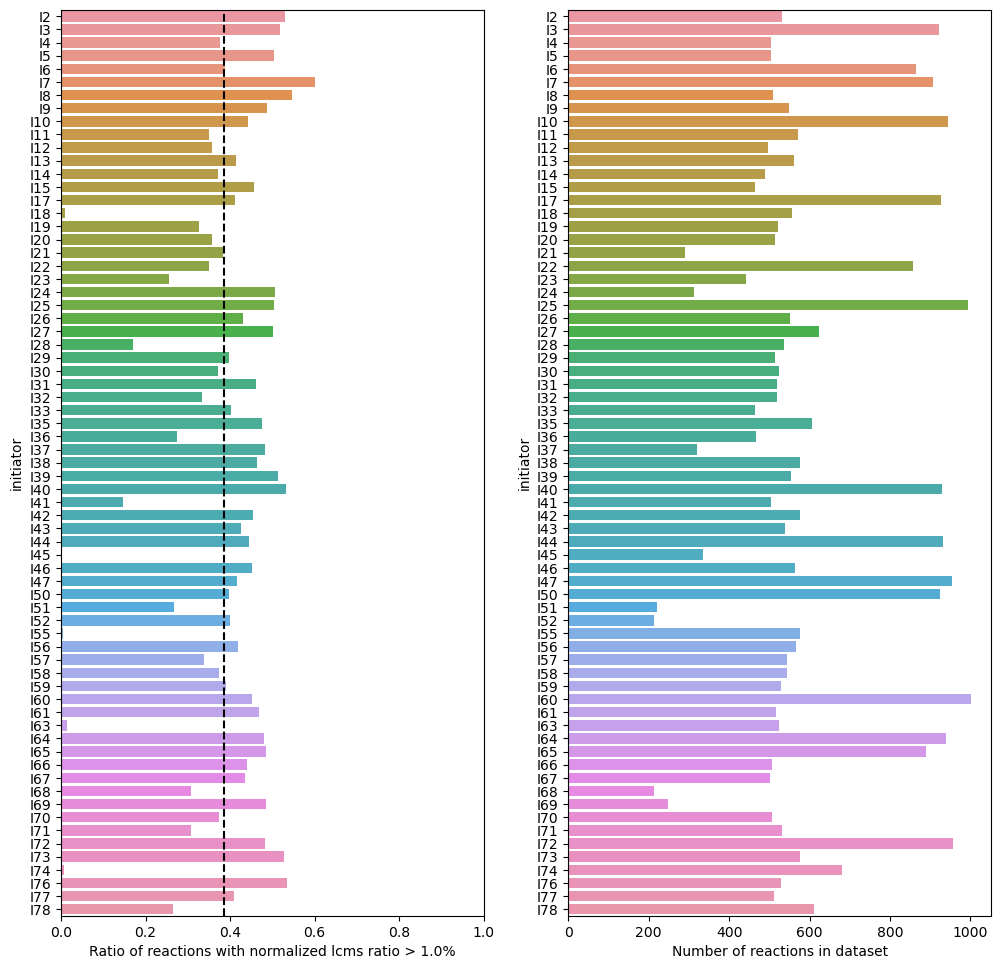

In [31]:
# show how many reactions are successful for each initiator
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

axs[0].axvline(success_rates_by_initiator['success_rate'].mean(), ls='--', c='black')  # draw a mean line
sns.barplot(x=success_rates_by_initiator['success_rate'], y=success_rates_by_initiator['initiator'], ax=axs[0])
sns.barplot(x=success_rates_by_initiator['n_all'], y=success_rates_by_initiator['initiator'], ax=axs[1])

axs[0].set_xlabel(f'Ratio of reactions with normalized lcms ratio > {THRESHOLD:.1%}')
axs[0].set_xlim(0,1)
axs[1].set_xlabel('Number of reactions in dataset')

plt.show()

In [32]:
db.get_smiles("T18")

'Cc1cccc(S)c1N'

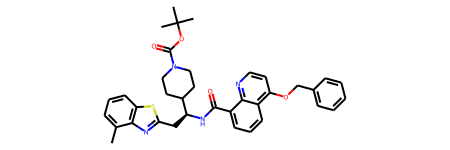

In [33]:
db.get_vl_member(65085)

In [34]:
df.columns

Index(['exp_nr', 'plate_nr', 'well', 'lab_journal_number',
       'synthesis_date_unixepoch', 'initiator', 'monomer', 'terminator',
       'initiator_long', 'monomer_long', 'terminator_long', 'long_name',
       'product_A_lcms_ratio', 'product_B_lcms_ratio', 'product_C_lcms_ratio',
       'product_D_lcms_ratio', 'product_E_lcms_ratio', 'product_F_lcms_ratio',
       'product_G_lcms_ratio', 'product_H_lcms_ratio', 'comment',
       'product_A_smiles', 'product_B_smiles', 'product_C_smiles',
       'product_D_smiles', 'product_E_smiles', 'product_F_smiles',
       'product_G_smiles', 'product_H_smiles', 'vl_id', 'valid',
       'A_normalized', 'B_normalized', 'C_normalized', 'D_normalized',
       'E_normalized', 'F_normalized', 'G_normalized', 'H_normalized',
       'initiator_type', 'monomer_type', 'terminator_type'],
      dtype='object')

In [35]:
(df.loc[df["terminator"] == "T9"]
   # .loc[df["well"] == "B21", :]
)

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized,initiator_type,monomer_type,terminator_type
id,,,,,,,,,,,,,,,,,,,,,
32083,13,5,A11,JG307,2022-03-15,I39,M4,T9,BiPh002,Fused011,...,0.0,0.0,0.000114,0.014194,0.005684,0.003364,0.000000,KAT_arom,Mon_fused,TerABT
32093,13,5,A21,JG307,2022-03-15,I39,M54,T9,BiPh002,Mon100,...,0.0,0.0,0.002287,0.027547,0.028773,0.015421,0.000000,KAT_arom,Mon_sub_2,TerABT
32103,13,5,B11,JG307,2022-03-15,I2,M4,T9,2-Pyr003,Fused011,...,0.0,0.0,0.000000,0.032207,0.017811,0.001489,0.000000,KAT_hetarom,Mon_fused,TerABT
32113,13,5,B21,JG307,2022-03-15,I2,M54,T9,2-Pyr003,Mon100,...,0.0,0.0,0.000232,0.031893,0.020318,0.007293,0.000000,KAT_hetarom,Mon_sub_2,TerABT
32153,13,5,D21,JG307,2022-03-15,I13,M54,T9,3-Pyr004,Mon100,...,0.0,0.0,0.000000,0.034711,0.001376,0.000000,0.000000,KAT_hetarom,Mon_sub_2,TerABT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74913,13,3,N21,JG305,2022-03-15,I9,M18,T9,2-Thio001,Mon015,...,0.0,0.0,0.000025,0.031983,0.026015,0.003065,0.000045,KAT_hetarom,Mon_sub_3,TerABT
74923,13,3,O11,JG305,2022-03-15,I11,M22,T9,3-Pyr002,Mon020,...,0.0,0.0,0.001036,0.023697,0.013200,0.000424,0.000000,KAT_hetarom,Mon_sub_3,TerABT
74933,13,3,O21,JG305,2022-03-15,I11,M18,T9,3-Pyr002,Mon015,...,0.0,0.0,0.000221,0.032612,0.007818,0.000323,0.000000,KAT_hetarom,Mon_sub_3,TerABT


In [36]:
df.loc[38296, "vl_id"]

134900

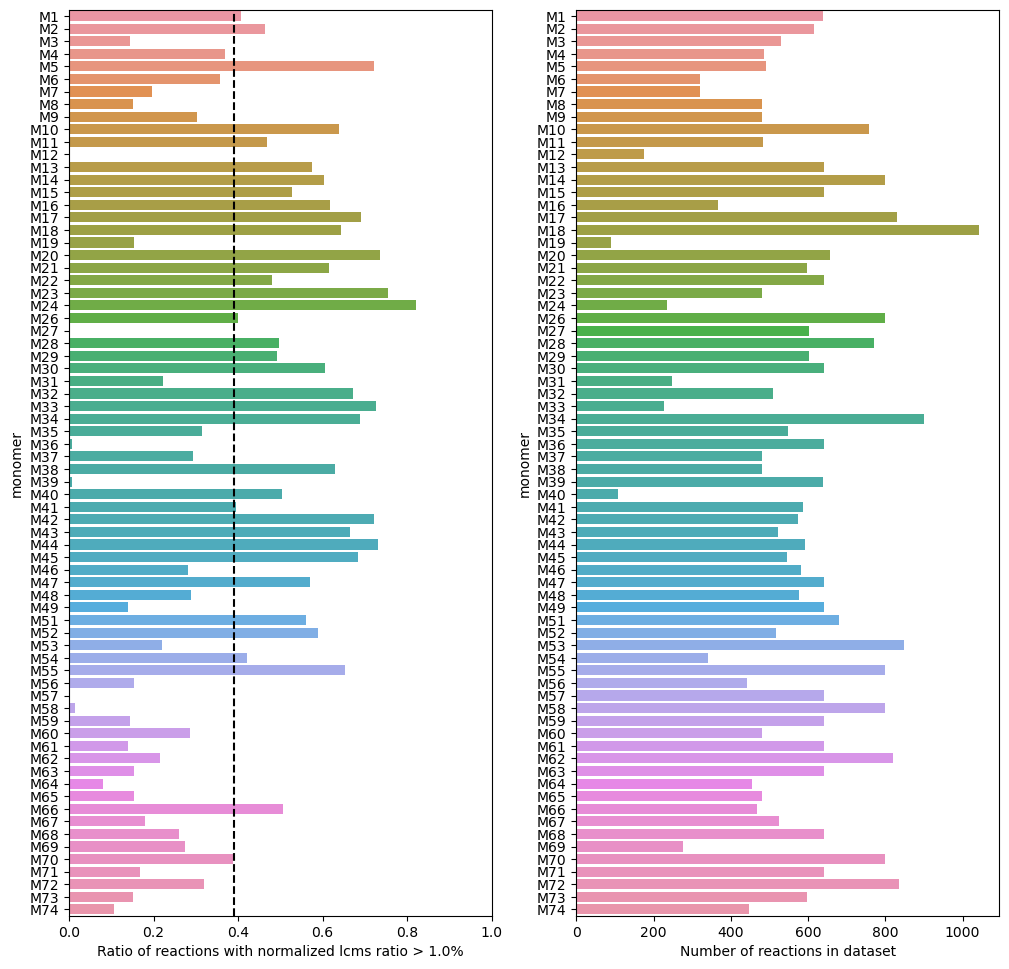

In [37]:
# show how many reactions are successful for each monomer
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

axs[0].axvline(success_rates_by_monomer['success_rate'].mean(), ls='--', c='black')
sns.barplot(x=success_rates_by_monomer['success_rate'], y=success_rates_by_monomer['monomer'], ax=axs[0])
sns.barplot(x=success_rates_by_monomer['n_all'], y=success_rates_by_monomer['monomer'], ax=axs[1])

axs[0].set_xlabel(f'Ratio of reactions with normalized lcms ratio > {THRESHOLD:.1%}')
axs[0].set_xlim(0,1)
axs[1].set_xlabel('Number of reactions in dataset')

plt.show()

/Users/julian/miniconda3/envs/library-generation/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:241: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


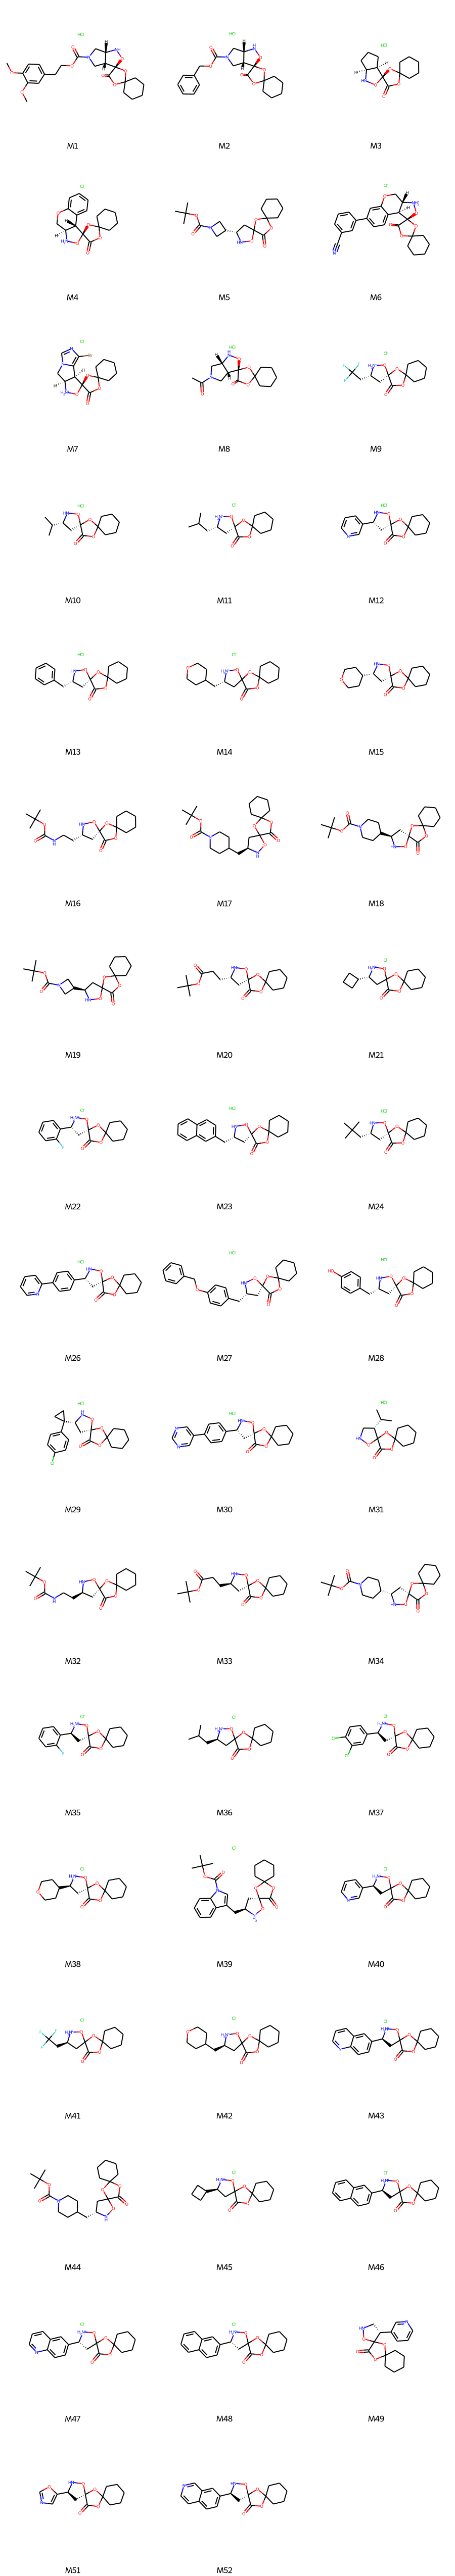

In [38]:
monomer_mols = []
for x in success_rates_by_monomer['monomer']:
    monomer_mols.append(db.get_mol(x))
Draw.MolsToGridImage(monomer_mols, subImgSize=(300, 300), legends=success_rates_by_monomer['monomer'].tolist())

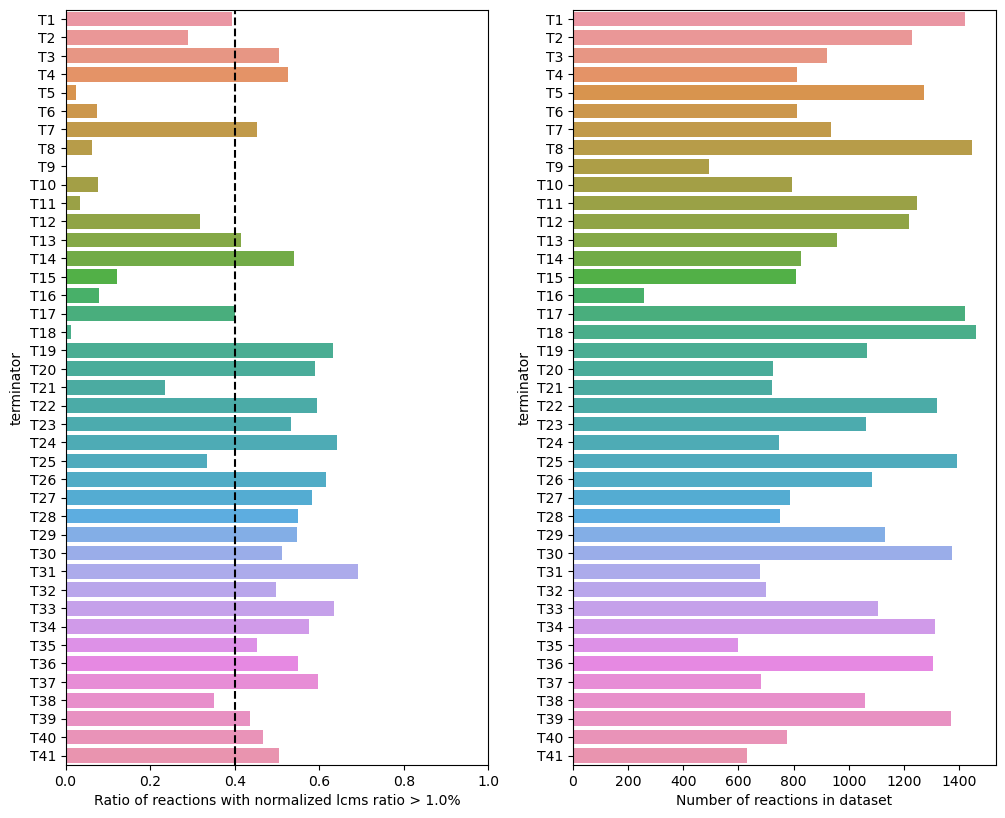

In [39]:
# show how many reactions are successful for each terminator
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,10))

axs[0].axvline(success_rates_by_terminator['success_rate'].mean(), ls='--', c='black')
sns.barplot(x=success_rates_by_terminator['success_rate'], y=success_rates_by_terminator['terminator'], ax=axs[0])
sns.barplot(x=success_rates_by_terminator['n_all'], y=success_rates_by_terminator['terminator'], ax=axs[1])

axs[0].set_xlabel(f'Ratio of reactions with normalized lcms ratio > {THRESHOLD:.1%}')
axs[0].set_xlim(0,1)
axs[1].set_xlabel('Number of reactions in dataset')

plt.show()

### Trends within builing block classes <a id=5></a>
Let's look at how well different types of initiators, monomers, terminators react

In [40]:
# let's check Initiators
success_rates_by_initiator_type = calc_success_rate(df, 'initiator_type', THRESHOLD, sort_results=False)
for _, i in success_rates_by_initiator_type.iterrows():
    print(f'Success rate for {i[0]}: {i[3]:.1%} ({i[1]}/{i[2]})')

Success rate for KAT_arom: 38.8% (7200/18545)
Success rate for KAT_al: 40.8% (2710/6641)
Success rate for KAT_hetarom: 40.5% (6281/15505)


In [41]:
# let's check Monomers
success_rates_by_monomer_type = calc_success_rate(df, 'monomer_type', THRESHOLD, sort_results=False)
for _, i in success_rates_by_monomer_type.iterrows():
    print(f'Success rate for {i[0]}: {i[1]/i[2]:.1%} ({i[1]}/{i[2]})')

Success rate for Mon_sub_3: 52.1% (12485/23961)
Success rate for Mon_fused: 31.0% (1050/3389)
Success rate for Mon_spiro_2: 22.1% (774/3502)
Success rate for Mon_spiro_3: 22.6% (1327/5880)
Success rate for Mon_sub_2: 14.0% (555/3959)


In [42]:
# let's check Terminators
success_rates_by_terminator_type = calc_success_rate(df, 'terminator_type', THRESHOLD, sort_results=False)
for _, i in success_rates_by_terminator_type.iterrows():
    print(f'Success rate for {i[0]}: {i[1]/i[2]:.1%} ({i[1]}/{i[2]})')

Success rate for TerTH: 52.5% (11743/22368)
Success rate for TerABT: 24.3% (4448/18323)


### Trends controlled for monomer behavior <a id=6></a>
Here we want to look at initiator and terminator success rates only for those monomers that typically work.
For simplicity, we accept only monomers that are have a success ratio of >= 10%

In [43]:
successful_monomers = success_rates_by_monomer.loc[success_rates_by_monomer['success_rate'] >= 0.10, 'monomer']
successful_monomers

0      M1
1      M2
2      M3
3      M4
4      M5
     ... 
67    M70
68    M71
69    M72
70    M73
71    M74
Name: monomer, Length: 65, dtype: object

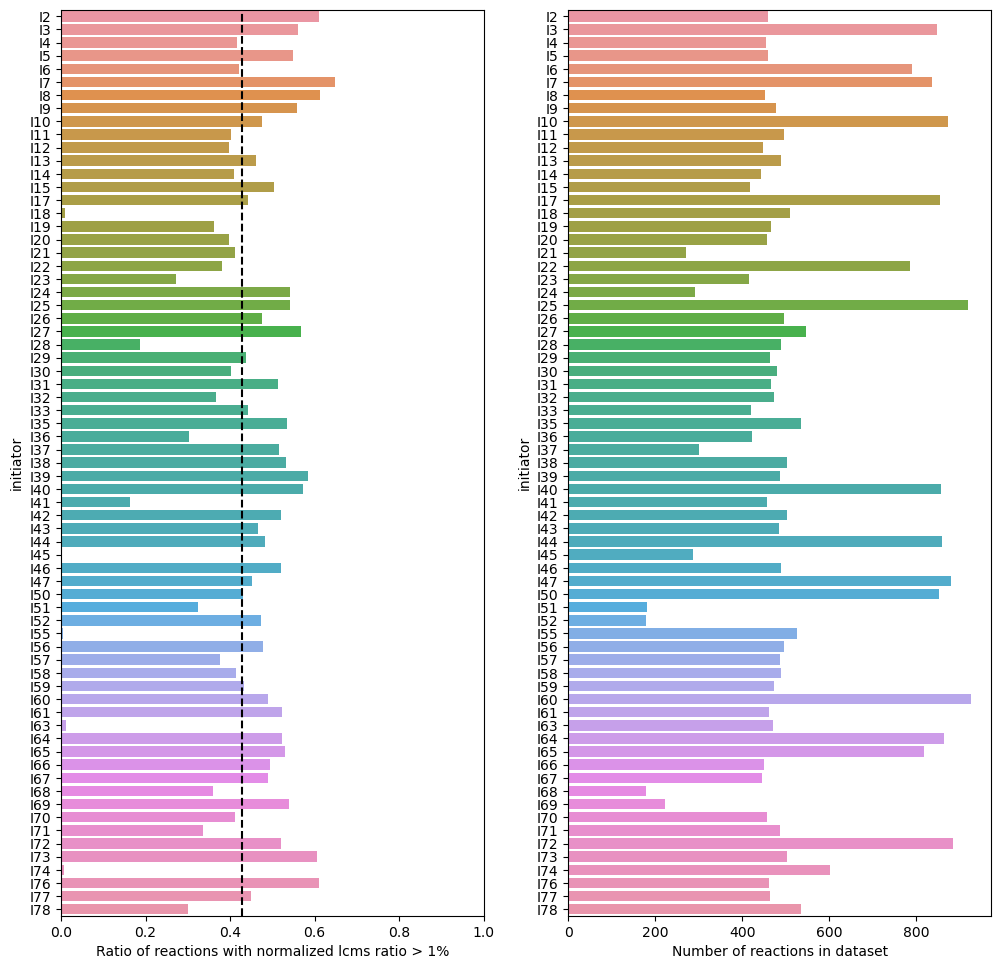

In [44]:
success_rates_by_initiator_for_successful_monomers = calc_success_rate(df.loc[df['monomer'].isin(successful_monomers)], 'initiator', THRESHOLD)

# show how many reactions are successful for each initiator, only considering monomers that react well
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
axs[0].axvline(success_rates_by_initiator_for_successful_monomers['success_rate'].mean(), ls='--', c='black')
sns.barplot(x=success_rates_by_initiator_for_successful_monomers['success_rate'], y=success_rates_by_initiator_for_successful_monomers['initiator'], ax=axs[0])
axs[0].set_xlabel(f'Ratio of reactions with normalized lcms ratio > {THRESHOLD:.0%}')
axs[0].set_xlim(0,1)

sns.barplot(x=success_rates_by_initiator_for_successful_monomers['n_all'], y=success_rates_by_initiator_for_successful_monomers['initiator'], ax=axs[1])
axs[1].set_xlabel('Number of reactions in dataset')
plt.show()

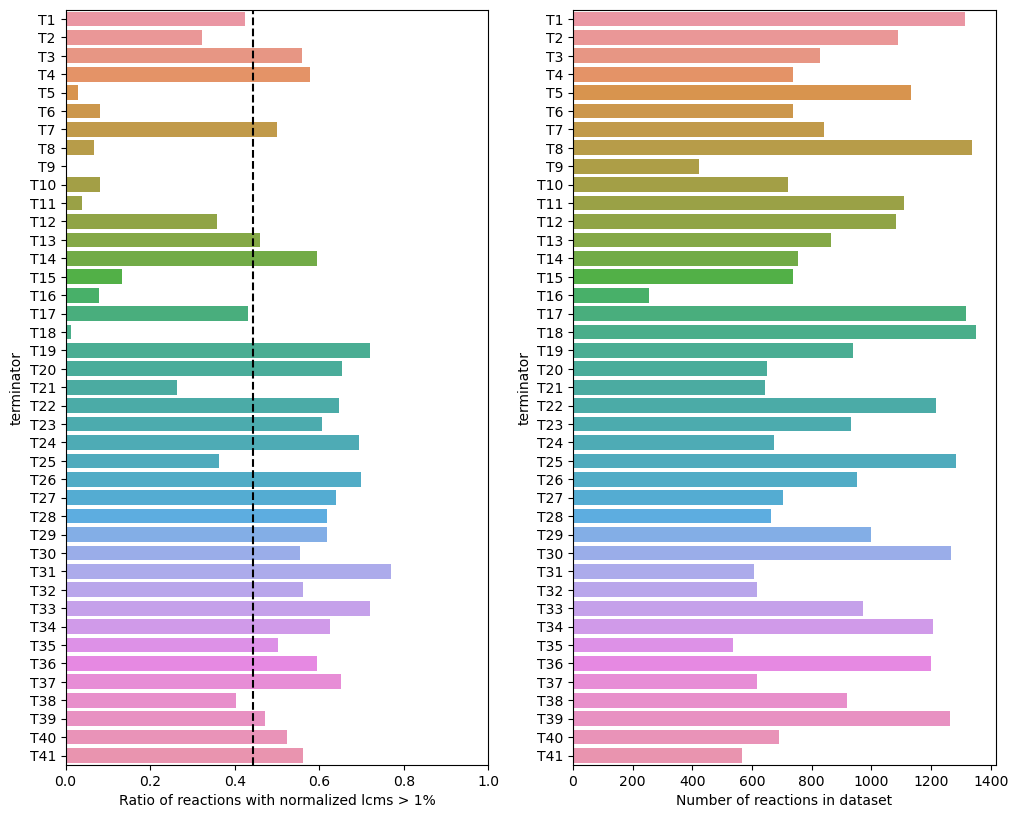

In [45]:
success_rates_by_terminator_for_successful_monomers = calc_success_rate(df.loc[df['monomer'].isin(successful_monomers)], 
                                                                        'terminator', 
                                                                        THRESHOLD,
                                                                       )

# show how many reactions are successful for each terminator, only considering monomers that react well
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
sns.barplot(x=success_rates_by_terminator_for_successful_monomers['success_rate'], y=success_rates_by_terminator_for_successful_monomers['terminator'], ax=axs[0])
axs[0].axvline(success_rates_by_terminator_for_successful_monomers['success_rate'].mean(), ls='--', c='black')
axs[0].set_xlabel(f'Ratio of reactions with normalized lcms > {THRESHOLD:.0%}')
axs[0].set_xlim(0,1)

sns.barplot(x=success_rates_by_terminator_for_successful_monomers['n_all'], y=success_rates_by_terminator_for_successful_monomers['terminator'], ax=axs[1])
axs[1].set_xlabel('Number of reactions in dataset')
plt.show()

What remains to do?

- Investigate what happens to the monomers where no product A is formed: Do they stall at F/G? Do they not react and we get a lot of D or H instead?

In [46]:
db.show_image('I63')